In [1]:
import matplotlib.pyplot as plt
import numpy as np
import physbo

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from shap import KernelExplainer

shap = dict()

def training_GP_shap( X_tr, y_tr, X_ts, y_ts, idx_tr, idx_ts ):

    global shap
    
    cov  = physbo.gp.cov.gauss( X_tr.shape[1], ard = False )
    mean = physbo.gp.mean.const()
    lik  = physbo.gp.lik.gauss()
    gp = physbo.gp.model( lik=lik, mean=mean, cov=cov )
    config = physbo.misc.set_config()
    gp.fit( X_tr, y_tr, config )
    gp.prepare( X_tr, y_tr )
    
    pred_y_tr = gp.get_post_fmean( X_tr, X_tr )
    pred_y_ts = gp.get_post_fmean( X_tr, X_ts )

    explainer = KernelExplainer(
        model = lambda var: gp.get_post_fmean(X_tr, var),
        data = X_ts,
        feature_perturbation='interventional'   
        )

    shap_val = explainer( X_ts )
    shap_val.feature_names = ['angle','TEP','NMR', 'p$K_\mathrm{a}$', 'ion-R', '$\mathrm{\delta_D}$', '$\mathrm{\delta_P}$', '$\mathrm{\delta_H}$']
    shap.update( dict(zip(idx_ts, shap_val)))
    
    y_test_all.extend( y_ts )
    y_test_pred_all.extend( pred_y_ts )
    y_train_all.extend( y_tr )
    y_train_pred_all.extend( pred_y_tr )
    
    MSEs, MAEs = calc_PFI_many( gp, X_tr, X_ts, y_ts )
    PFI_MSE.append( MSEs )
    PFI_MAE.append( MAEs )
    
    print( 'R(training):', r2_score( pred_y_tr, y_tr) )
    print( 'R(test):', r2_score( pred_y_ts, y_ts) )
    
    return

def k_fold_split( X, y, k, shuffle=True, random_seed=None ):

    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    if shuffle:
        if random_seed is not None:
            np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_indices, test_indices))
        current = stop
    
    return folds

def calc_PFI( gp, X_tr, X_ts, y_ts ):
    
    from copy import deepcopy
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    
    MSEs = []
    MAEs = []
    
    for i in range( X_ts.shape[1] ):
        X_shuffle = deepcopy( X_ts )
        np.random.shuffle( X_shuffle[:,i] )
        y_pred = gp.get_post_fmean( X_tr, X_ts )
        y_shuffle_pred = gp.get_post_fmean( X_tr, X_shuffle )
        MSEs.append( mean_squared_error( y_pred, y_shuffle_pred ) )
        MAEs.append( mean_absolute_error( y_pred, y_shuffle_pred ) )
    
    return MSEs, MAEs

def calc_PFI_many( gp, X_tr, X_ts, y_ts, nrun = 1000 ):
    
    from copy import deepcopy
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    
    MSEs = []
    MAEs = []
    
    for i in range( X_ts.shape[1] ):
        sh_preds = []
        for j in range( nrun ):
            X_shuffle = deepcopy( X_ts )
            np.random.shuffle( X_shuffle[:,i] )
            y_shuffle_pred = gp.get_post_fmean( X_tr, X_shuffle )
            sh_preds.append( y_shuffle_pred )
        
        y_sh_pred = sum( sh_preds ) / len( sh_preds )
        y_pred = gp.get_post_fmean( X_tr, X_ts )
        
        MSEs.append( mean_squared_error( y_pred, y_sh_pred ) )
        MAEs.append( mean_absolute_error( y_pred, y_sh_pred ) )
    
    return MSEs, MAEs

In [2]:
seed = 123456

import pandas as pd
df = pd.read_csv( '2024_0712_0146_candidates.csv' )
dat = df.iloc[:,4:].dropna()
X = dat.iloc[:,0:8].to_numpy()
y = dat.iloc[:,8].to_numpy()

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 402.15367488236245
50 -th epoch marginal likelihood 321.1658665185066
100 -th epoch marginal likelihood 278.3379522313626
150 -th epoch marginal likelihood 255.1984352220586
200 -th epoch marginal likelihood 242.28017352718825
250 -th epoch marginal likelihood 233.26237156209277
300 -th epoch marginal likelihood 226.92005573036755
350 -th epoch marginal likelihood 221.70111108420156
400 -th epoch marginal likelihood 217.18835624072983
450 -th epoch marginal likelihood 214.29459055861713
500 -th epoch marginal likelihood 210.58077875202775
Done



  0%|          | 0/36 [00:00<?, ?it/s]

R(training): 0.9800765710930887
R(test): 0.07643343415526793
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 248.19628336402243
50 -th epoch marginal likelihood 214.14158969474408
100 -th epoch marginal likelihood 199.24264062259294
150 -th epoch marginal likelihood 192.02462357992187
200 -th epoch marginal likelihood 187.91535457014118
250 -th epoch marginal likelihood 185.01014809370636
300 -th epoch marginal likelihood 182.59983794975187
350 -th epoch marginal likelihood 180.28621103986984
400 -th epoch marginal likelihood 178.29774850950326
450 -th epoch marginal likelihood 176.5796054645917
500 -th epoch marginal likelihood 175.33661434708614
Done



  0%|          | 0/36 [00:00<?, ?it/s]

R(training): 0.9840429200632158
R(test): -0.028266978034291235
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 399.42502452253865
50 -th epoch marginal likelihood 325.0102980053223
100 -th epoch marginal likelihood 284.9094728205491
150 -th epoch marginal likelihood 261.0335419682012
200 -th epoch marginal likelihood 246.07860444487153
250 -th epoch marginal likelihood 235.00085184100914
300 -th epoch marginal likelihood 227.99691307437521
350 -th epoch marginal likelihood 222.9129344084535
400 -th epoch marginal likelihood 218.52534529090144
450 -th epoch marginal likelihood 215.43041195775538
500 -th epoch marginal likelihood 211.5098668683405
Done



  0%|          | 0/36 [00:00<?, ?it/s]

R(training): 0.9804555894622585
R(test): -0.23817052340699285
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 369.9465032028884
50 -th epoch marginal likelihood 297.1914707806722
100 -th epoch marginal likelihood 261.2707568291443
150 -th epoch marginal likelihood 241.73163256742706
200 -th epoch marginal likelihood 228.25469207181322
250 -th epoch marginal likelihood 219.73156860219495
300 -th epoch marginal likelihood 213.96634642792662
350 -th epoch marginal likelihood 209.63212290888617
400 -th epoch marginal likelihood 206.13516693466187
450 -th epoch marginal likelihood 203.04994292242972
500 -th epoch marginal likelihood 200.25451607806116
Done



  0%|          | 0/35 [00:00<?, ?it/s]

R(training): 0.9802368152743949
R(test): -0.4129753320220113
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 389.39880192743084
50 -th epoch marginal likelihood 313.43706720610305
100 -th epoch marginal likelihood 273.4749580368838
150 -th epoch marginal likelihood 249.08914425972443
200 -th epoch marginal likelihood 235.26545397751948
250 -th epoch marginal likelihood 225.8209500429192
300 -th epoch marginal likelihood 220.68959151072835
350 -th epoch marginal likelihood 216.8084616382733
400 -th epoch marginal likelihood 213.4769948813664
450 -th epoch marginal likelihood 210.77526157542036
500 -th epoch marginal likelihood 207.76153290210925
Done



  0%|          | 0/35 [00:00<?, ?it/s]

R(training): 0.9858873296010549
R(test): 0.2556493220195234
R(train all): 0.9833804598961507
R(test all): 0.4570087288340422


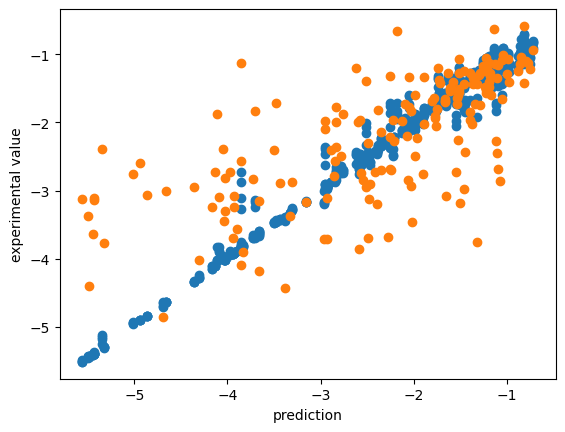

In [3]:
X = physbo.misc.centering( X )
fold = 5
cross_dats = k_fold_split( X, y, fold, random_seed=seed )

y_test_all = []
y_test_pred_all = []
y_train_all = []
y_train_pred_all = []
PFI_MSE = []
PFI_MAE = []

for i in range(fold):
    idx_tr, idx_ts = cross_dats[i]
    training_GP_shap( X[idx_tr], y[idx_tr], X[idx_ts], y[idx_ts], idx_tr, idx_ts )

from sklearn.metrics import r2_score
print( 'R(train all):', r2_score(y_train_all, y_train_pred_all) )
print( 'R(test all):', r2_score(y_test_all, y_test_pred_all) )

plt.xlabel("prediction")
plt.ylabel("experimental value")
plt.scatter( y_train_all, y_train_pred_all )
plt.scatter( y_test_all, y_test_pred_all )

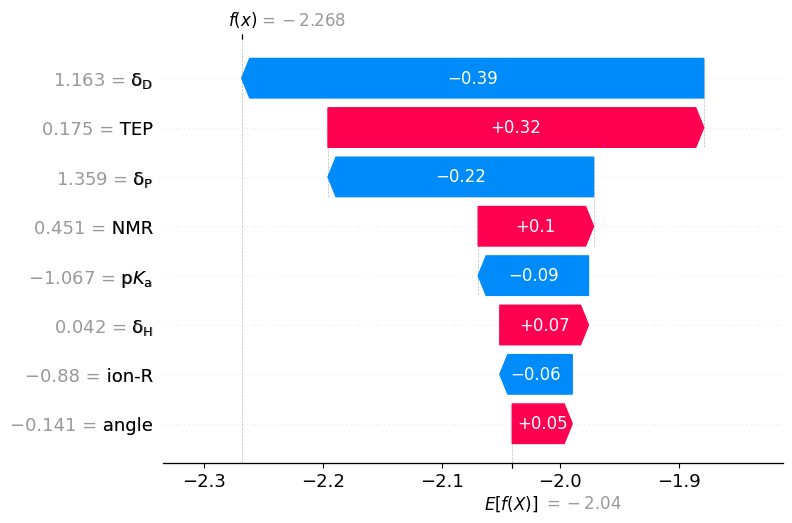

In [4]:
from shap import plots
plots.waterfall( shap[0] )

In [5]:
shap_vals = [list(map(abs, x.values)) for x in shap.values()]
shap_all = [sum(x) for x in zip(*shap_vals)]
#shap_all_normalized = [round(x/max(shap_all), 3) for x in shap_all]
shap_all_normalized = [x for x in shap_all]
shap_all_normalized

[16.412461151065884,
 50.24685286948097,
 19.065871145577862,
 20.66565982336957,
 16.563542668767177,
 24.891453509016156,
 25.93761319453573,
 62.86379772063329]

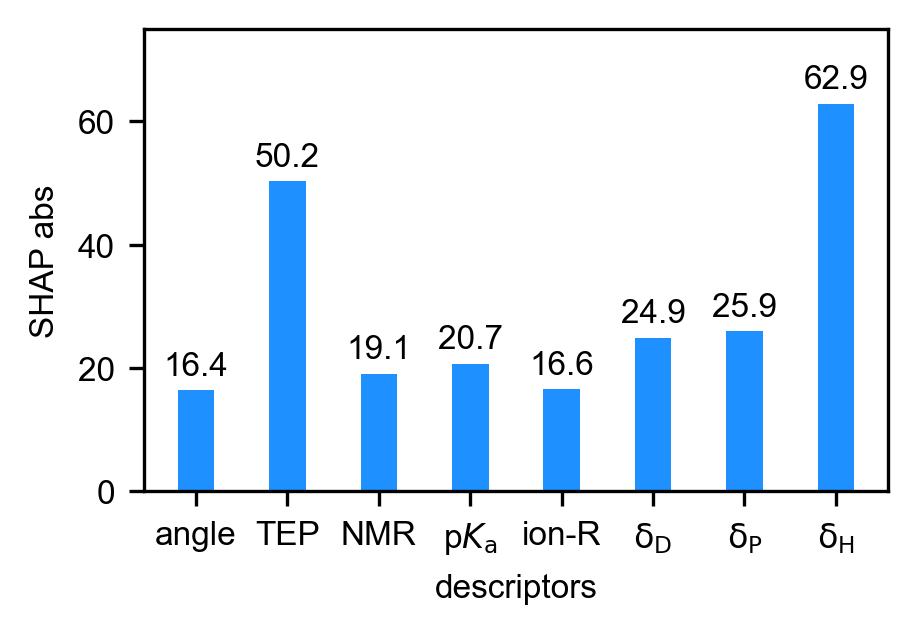

In [6]:
import matplotlib.pyplot as plt

labels = shap[0].feature_names
width = 0.4

plt.rcParams['font.family'] = 'arial' # font familyの設定
plt.rcParams["font.size"] = 8        # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.direction'] = 'out' #x軸の目盛りの向き
plt.rcParams['ytick.direction'] = 'out' #y軸の目盛りの向き

fig, ax = plt.subplots( figsize=(3.2, 2), dpi=300 )

ax.set_ylim( 0, 75 )
ax.set_ylabel('SHAP abs')
ax.set_xlabel('descriptors')
rect = ax.bar(labels, shap_all_normalized, width, color='dodgerblue')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        #annotationで文字やその位置を定義。文字を改行したいときは\nを挟む。
        ax.annotate('{:.1f}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0,2),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=8)

autolabel( rect )

plt.savefig('PFI.svg', bbox_inches='tight')

In [7]:
best20 = [32, 59, 90, 31, 33, 30, 55, 71, 73, 146]

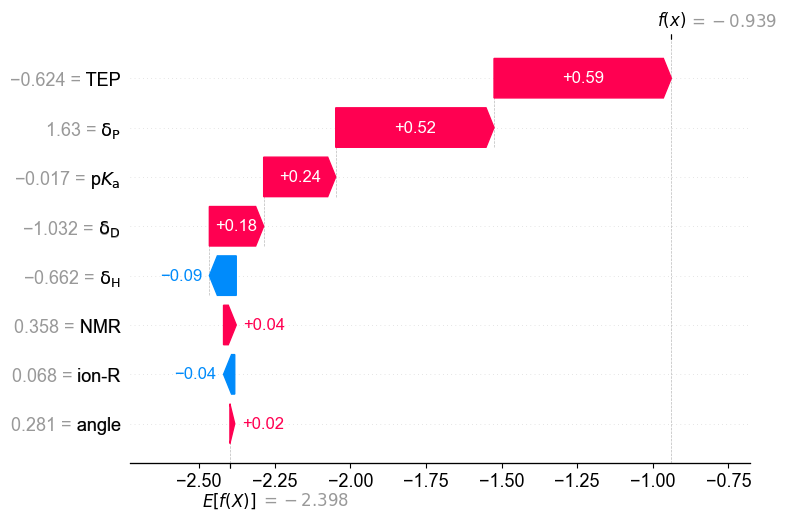

In [8]:
i = 0
plots.waterfall( shap[best20[i]] )

In [9]:
shap_sorted = np.array([list(x.values) for i, x in sorted(shap.items())])
shap_sorted

array([[ 0.05051415,  0.31647735,  0.09719681, ..., -0.38914489,
        -0.22368517,  0.07470305],
       [-0.00434907,  0.06063016,  0.04808909, ..., -0.48617546,
        -0.23709698, -0.09018733],
       [-0.1583704 , -1.08205871,  0.19245151, ..., -0.1659817 ,
        -0.02921994,  0.05559501],
       ...,
       [ 0.01711448,  0.07962906, -0.04569009, ..., -0.3411326 ,
        -0.60542355, -0.88143138],
       [-0.05552659, -0.27855779, -0.09039494, ..., -0.10785638,
        -0.15245204, -0.5310562 ],
       [-0.21834155, -0.00668191, -0.15502363, ...,  0.04350468,
        -0.16830295, -0.37316655]])

C:\Users\ERATO1\AppData\Local\Temp\ipykernel_4332\1952918970.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot(shap_sorted, X, feature_names=['angle','TEP','NMR', 'p$K_\mathrm{a}$','ion-R', '$\mathrm{\delta_D}$', '$\mathrm{\delta_P}$', '$\mathrm{\delta_H}$'], sort=False, show=False)


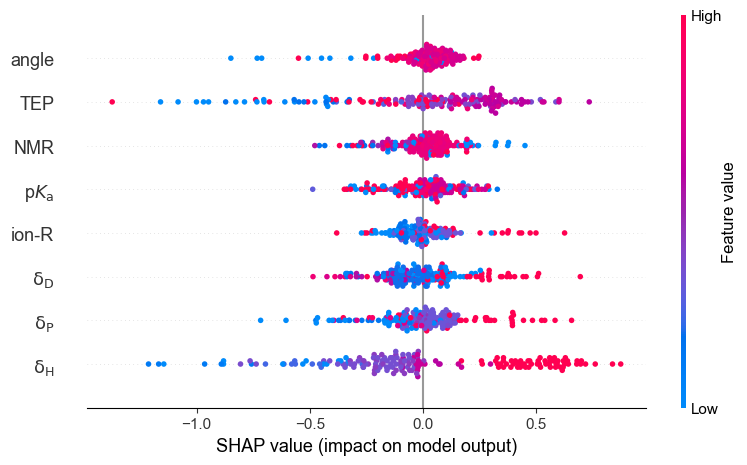

In [10]:
from shap import summary_plot
summary_plot(shap_sorted, X, feature_names=['angle','TEP','NMR', 'p$K_\mathrm{a}$','ion-R', '$\mathrm{\delta_D}$', '$\mathrm{\delta_P}$', '$\mathrm{\delta_H}$'], sort=False, show=False)
plt.savefig('shap_summary_dots.png', dpi=300, bbox_inches='tight')

C:\Users\ERATO1\AppData\Local\Temp\ipykernel_4332\3679520987.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot(shap_sorted, X, plot_type='violin', feature_names=['angle','TEP','NMR', 'p$K_\mathrm{a}$', 'ion-R', '$\mathrm{\delta_D}$', '$\mathrm{\delta_P}$', '$\mathrm{\delta_H}$'], sort=False, show=False)


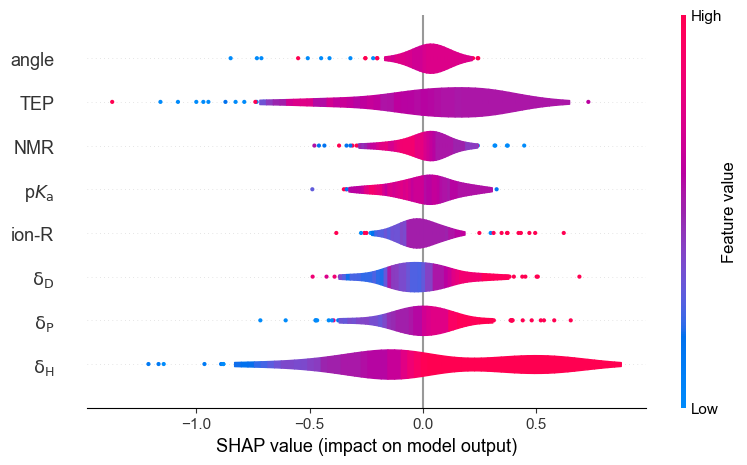

In [11]:
from shap import summary_plot
summary_plot(shap_sorted, X, plot_type='violin', feature_names=['angle','TEP','NMR', 'p$K_\mathrm{a}$', 'ion-R', '$\mathrm{\delta_D}$', '$\mathrm{\delta_P}$', '$\mathrm{\delta_H}$'], sort=False, show=False)
plt.savefig('shap_summary_violin.png', dpi=300, bbox_inches='tight')

In [12]:
X = physbo.misc.centering( X )
fold = 5
cross_dats = k_fold_split( X, y, fold, random_seed=seed )

y_test_all = []
y_test_pred_all = []
y_train_all = []
y_train_pred_all = []
PFI_MSE = []
PFI_MAE = []

for i in range(fold):

    idx_tr = cross_dats[i]
    training_GP( X[idx_tr[0]], y[idx_tr[0]], X[idx_tr[1]], y[idx_tr[1]] )
    print(i)

from sklearn.metrics import r2_score
print( 'R(train all):', r2_score(y_train_all, y_train_pred_all) )
print( 'R(test all):', r2_score(y_test_all, y_test_pred_all) )

plt.xlabel("prediction")
plt.ylabel("experimental value")
plt.scatter( y_train_all, y_train_pred_all )
plt.scatter( y_test_all, y_test_pred_all )

NameError: name 'training_GP' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import physbo

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def training_RF( X_tr, y_tr, X_ts, y_ts ):

    rf =  RandomForestRegressor()
    alpha_list = [10,20,50,100,200]
    params = {'max_depth': alpha_list}
    rf_GSCV = GridSearchCV(rf, params, cv=5, scoring='neg_mean_squared_error')
    rf_GSCV.fit(X_tr, y_tr)

    rf = RandomForestRegressor(max_depth=rf_GSCV.best_params_['max_depth'])
    rf.fit(X_tr, y_tr)

    y_test_all.extend( y_ts )
    y_test_pred_all.extend( rf.predict( X_ts ) )
    y_train_all.extend( y_tr )
    y_train_pred_all.extend( rf.predict( X_tr ) )
    
    print( 'R(training):', r2_score(rf.predict(X_tr), y_tr) )
    print( 'R(test):', r2_score(rf.predict(X_ts), y_ts) )
    
    return

def training_GP( X_tr, y_tr, X_ts, y_ts ):

    cov  = physbo.gp.cov.gauss( X_tr.shape[1], ard = False )
    mean = physbo.gp.mean.const()
    lik  = physbo.gp.lik.gauss()
    gp = physbo.gp.model( lik=lik, mean=mean, cov=cov )
    config = physbo.misc.set_config()
    gp.fit( X_tr, y_tr, config )
    gp.prepare( X_tr, y_tr )
    
    pred_y_tr = gp.get_post_fmean( X_tr, X_tr )
    pred_y_ts = gp.get_post_fmean( X_tr, X_ts )

    y_test_all.extend( y_ts )
    y_test_pred_all.extend( pred_y_ts )
    y_train_all.extend( y_tr )
    y_train_pred_all.extend( pred_y_tr )
    
    #MSEs, MAEs = calc_PFI_many( gp, X_tr, X_ts, y_ts )
    #PFI_MSE.append( MSEs )
    #PFI_MAE.append( MAEs )
    
    print( 'R(training):', r2_score( pred_y_tr, y_tr) )
    print( 'R(test):', r2_score( pred_y_ts, y_ts) )
    
    return

def k_fold_split( X, y, k, shuffle=True, random_seed=None ):

    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    if shuffle:
        if random_seed is not None:
            np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_indices, test_indices))
        current = stop
    
    return folds

def calc_PFI( gp, X_tr, X_ts, y_ts ):
    
    from copy import deepcopy
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    
    MSEs = []
    MAEs = []
    
    for i in range( X_ts.shape[1] ):
        X_shuffle = deepcopy( X_ts )
        np.random.shuffle( X_shuffle[:,i] )
        y_pred = gp.get_post_fmean( X_tr, X_ts )
        y_shuffle_pred = gp.get_post_fmean( X_tr, X_shuffle )
        MSEs.append( mean_squared_error( y_pred, y_shuffle_pred ) )
        MAEs.append( mean_absolute_error( y_pred, y_shuffle_pred ) )
    
    return MSEs, MAEs

def calc_PFI_many( gp, X_tr, X_ts, y_ts, nrun = 1000 ):
    
    from copy import deepcopy
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    
    MSEs = []
    MAEs = []
    
    for i in range( X_ts.shape[1] ):
        sh_preds = []
        for j in range( nrun ):
            X_shuffle = deepcopy( X_ts )
            np.random.shuffle( X_shuffle[:,i] )
            y_shuffle_pred = gp.get_post_fmean( X_tr, X_shuffle )
            sh_preds.append( y_shuffle_pred )
        
        y_sh_pred = sum( sh_preds ) / len( sh_preds )
        y_pred = gp.get_post_fmean( X_tr, X_ts )
        
        
        MSEs.append( mean_squared_error( y_pred, y_sh_pred ) )
        MAEs.append( mean_absolute_error( y_pred, y_sh_pred ) )
    
    return MSEs, MAEs

seed = 123456

import pandas as pd
df = pd.read_csv( '2024_0712_0146_candidates.csv' )
dat = df.iloc[:,4:].dropna()
X = dat.iloc[:,0:8].to_numpy()
y = dat.iloc[:,8].to_numpy()

X = physbo.misc.centering( X )
fold = 5
cross_dats2 = k_fold_split( X, y, fold, random_seed=seed )
cross_dats2

In [ ]:
cross_dats